In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text

from scipy.signal import spectrogram
import librosa
from utils import parse_yaml, load_ss_model
from dcase_evaluator_analysis import DCASEEvaluatorAnalysis
import torch
import gc
import numpy as np

/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfshomes/vla/lass-final-project/models/CLAP/open_clip/factory.py:55: FutureWarning: You a

In [4]:
def eval(evaluator,
         encoder_checkpoint_path = None, 
         ssnet_checkpoint_path = None, 
         config_yaml=None, 
         device = "cuda",
         encoder_type = None):

    
    assert encoder_type is not None, 'define encoder type'
    
    configs = parse_yaml(config_yaml)
    
    if encoder_type == 'ONE-PEACE':

        from models.one_peace_encoder import ONE_PEACE_Encoder
        # ONE_PEACE modelhub expects some paths to be relative to this dir
        os.chdir('ONE-PEACE/')
        # TODO:path in shared scratch dir for now..., move to class project dir whenever we get that
        query_encoder = ONE_PEACE_Encoder(pretrained_path=encoder_checkpoint_path)
        os.chdir('..')

        # put ONE-PEACE model in eval model (probably unecessary)
        query_encoder.model.model.eval()

    elif encoder_type == 'CLAP':
        from models.clap_encoder import CLAP_Encoder
        query_encoder = CLAP_Encoder(pretrained_path=encoder_checkpoint_path).eval()

    pl_model = load_ss_model(
        configs=configs,
        checkpoint_path=ssnet_checkpoint_path,
        query_encoder=query_encoder
    ).to(device)


    print(f'-------  Start Evaluation  -------')
    df_results = evaluator(pl_model)
    df_results.to_csv(os.path.join(evaluator.output_dir,f'{encoder_type}_output.csv'), index = None)
    print('-------------------------  Done  ---------------------------')

    del pl_model
    del evaluator
    
    torch.cuda.empty_cache()
    gc.collect()

    return df_results

In [5]:
sampling_rate = 16000
pd.set_option('display.max_colwidth', None)

In [6]:
op_config_yaml = 'config/audiosep_onepeace.yaml'
op_encoder_checkpoint_path = '/fs/nexus-scratch/vla/finetune_al_retrieval.pt'
op_ssnet_checkpoint_path = '/fs/nexus-scratch/vla/checkpoints/train/audiosep_onepeace,devices=1/step=140000.ckpt'

clap_config_yaml = 'config/audiosep_base.yaml'
clap_encoder_checkpoint_path = './checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt'
clap_ssnet_checkpoint_path = 'checkpoint/audiosep_baseline.ckpt'

In [5]:
df_onepeace = pd.read_csv('results/one-peace_validation_results.csv')
df_clap = pd.read_csv('results/baseline_validation_results.csv')

#### Sword Swoosh/ Wave noise Example

In [6]:
clap_sample = df_clap.loc[285]
clap_sample

caption                                                  The sword swooshes through the air as someone waves it, making a whooshing sound.
source_path                                                                                         lass_validation/699930_10996917-hq.wav
noise_path                                                                                          lass_validation/683018_10624050-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_baseline_output/('699930_10996917-hq.wav', '683018_10624050-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_baseline_output/('699930_10996917-hq.wav', '683018_10624050-hq.wav')_output.wav
input_similarity                                                                                                                  0.390963
output_similarity                                                                                                                 0.560391
target_similarity          

In [7]:
onepeace_sample = df_onepeace.loc[285]
onepeace_sample

caption                                                  The sword swooshes through the air as someone waves it, making a whooshing sound.
source_path                                                                                         lass_validation/699930_10996917-hq.wav
noise_path                                                                                          lass_validation/683018_10624050-hq.wav
input_path            /fs/nexus-scratch/vla/lass_validation_onepeace_output/('699930_10996917-hq.wav', '683018_10624050-hq.wav')_input.wav
output_path          /fs/nexus-scratch/vla/lass_validation_onepeace_output/('699930_10996917-hq.wav', '683018_10624050-hq.wav')_output.wav
input_similarity                                                                                                                  0.163938
output_similarity                                                                                                                 0.315517
target_similarity          

In [8]:
caption = onepeace_sample.caption
caption

'The sword swooshes through the air as someone waves it, making a whooshing sound.'

In [9]:
df_synth_validation = pd.read_csv('lass_synthetic_validation.csv')
df_synth_validation[:2]

,source,noise,snr,caption
0,692211_12333864-hq,701692_6014995-hq,10,"Someone is playing a kind of musical instrument, which makes a buzzing sound."
1,692211_12333864-hq,708399_14710576-hq,1,"Someone is playing the musical instrument, which produces buzzing sounds."


In [10]:
# oops theres a space
df_synth_validation.columns

Index(['source', ' noise', ' snr', ' caption'], dtype='object')

In [11]:
df_eval = df_synth_validation[df_synth_validation[' caption'] == caption]
df_eval

,source,noise,snr,caption
285,699930_10996917-hq,683018_10624050-hq,15,"The sword swooshes through the air as someone waves it, making a whooshing sound."


In [ ]:
# slow and inefficient loop but im tired
captions = ['The sword slashes through the air.',
            'The sword makes a slashing sound.',
            'The sword slices through the air.',
            'The sword makes a slicing sound.',
            'Sword waving around.',
            'The waving sword swooshes around.',
            'The waving sword waves around wavily.',
           ]

for i,caption in enumerate(captions):

    output_dir = f'sword_wave_{i}'
    os.makedirs(output_dir, exist_ok=True)

    df_eval.loc[:,' caption'] = caption
    df_eval.to_csv('sword_wave_eval.csv', index = None)


    # ONE-PEACE eval
    dcase_evaluator = DCASEEvaluatorAnalysis(
        sampling_rate=16000,
        eval_indexes='sword_wave_eval.csv',
        audio_dir='lass_validation',
        output_dir = output_dir,
        encoder_type = 'ONE-PEACE'
    )

    df_results = eval(dcase_evaluator,
                    encoder_checkpoint_path = op_encoder_checkpoint_path,
                    ssnet_checkpoint_path = op_ssnet_checkpoint_path,
                    config_yaml = op_config_yaml,
                    device = "cuda",
                    encoder_type='ONE-PEACE'                  
    )
    torch.cuda.empty_cache()
    gc.collect()

    # CLAP eval
    dcase_evaluator = DCASEEvaluatorAnalysis(
        sampling_rate=16000,
        eval_indexes='sword_wave_eval.csv',
        audio_dir='lass_validation',
        output_dir = output_dir,
        encoder_type = 'CLAP'
    )

    df_results = eval(dcase_evaluator,
                    encoder_checkpoint_path = clap_encoder_checkpoint_path,
                    ssnet_checkpoint_path = clap_ssnet_checkpoint_path,
                    config_yaml = clap_config_yaml,
                    device = "cuda",
                    encoder_type='CLAP'                  
    )
    torch.cuda.empty_cache()
    gc.collect()
    
    with open(os.path.join(output_dir, 'caption.txt'), 'w') as f:
        f.write(caption)
        f.close()
    


/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/fairseq/checkpoint_utils.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, m

In [27]:
# interesting indices 0,2,6 + original

df_clap = pd.DataFrame()
df_op = pd.DataFrame()
for i in [0,2,6]:
    result = {}
    output_dir = f'sword_wave_{i}'
    clap_output = pd.read_csv(os.path.join(output_dir, 'CLAP_output.csv'))

    df_clap = pd.concat([df_clap, clap_output], ignore_index=True)


    op_output = pd.read_csv(os.path.join(output_dir, 'ONE-PEACE_output.csv'))
    df_op = pd.concat([df_op, op_output], ignore_index=True)

 

In [30]:
df_clap[['caption', 'input_similarity', 'output_similarity', 'target_similarity', 'sisdr', 'sdri', 'sdr']]

,caption,input_similarity,output_similarity,target_similarity,sisdr,sdri,sdr
0,The sword slashes through the air.,0.307211,0.313242,0.304953,28.022077,12.944131,27.944130
1,The sword slices through the air.,0.294347,0.290730,0.255574,28.422885,13.386739,28.386738
2,The waving sword waves around wavily,0.238028,0.218852,0.112427,5.634134,-8.318420,6.681579


In [32]:
df_op[['caption', 'input_similarity', 'output_similarity', 'target_similarity', 'sisdr', 'sdri', 'sdr']]

,caption,input_similarity,output_similarity,target_similarity,sisdr,sdri,sdr
0,The sword slashes through the air.,0.161676,0.414065,0.382297,0.859136,-11.784411,3.215588
1,The sword slices through the air.,0.242677,0.435143,0.456006,27.272389,12.102124,27.102123
2,The waving sword waves around wavily,0.158412,0.136753,0.243362,-39.099274,-15.075331,-0.075332


In [36]:
df_clap.to_csv('results/clap_sword_wave.csv', index = None)

In [35]:
df_op.to_csv('results/op_sword_wave.csv', index = None)

## Let's looking at how similar these captions are in the different embedding spaces

In [2]:
captions = ['The sword slashes through the air.',
            'The sword slices through the air.',
            'The waving sword waves around wavily.',
]

In [ ]:
from models.clap_encoder import CLAP_Encoder
clap_encoder = CLAP_Encoder(pretrained_path=clap_encoder_checkpoint_path).eval()
clap_encoder.to('cuda')

In [20]:
caption_embeddings = []
for caption in captions:
    caption_embeddings.append(clap_encoder._get_text_embed([caption]).cpu())

In [21]:
c_matrix = np.zeros((3,3))
for i in range(c_matrix.shape[0]):
    for j in range(i,c_matrix.shape[1]):
        c_matrix[i,j] = caption_embeddings[i] @ caption_embeddings[j].T
        c_matrix[j,i] = caption_embeddings[i] @ caption_embeddings[j].T

In [22]:
c_matrix

array([[0.99999982, 0.92073697, 0.66557372],
       [0.92073697, 1.        , 0.617055  ],
       [0.66557372, 0.617055  , 1.00000012]])

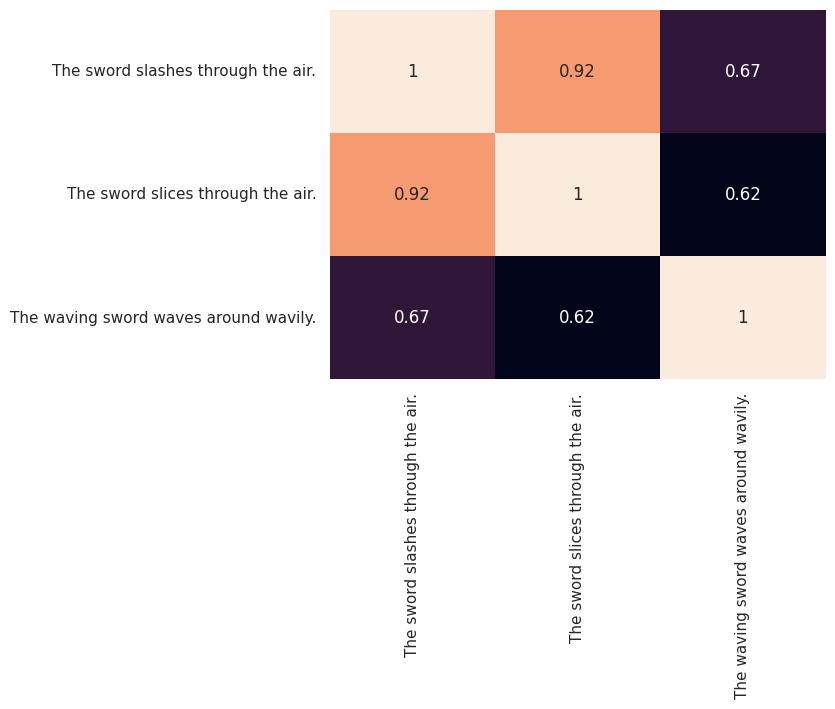

In [25]:
sns.set_theme()
sns.heatmap(c_matrix, xticklabels=captions, yticklabels=captions, annot=True, cbar=False)
# plt.tight_layout()
plt.savefig('plots/clap_cmatrix.png', dpi=600, bbox_inches = "tight")

In [ ]:
from models.one_peace_encoder import ONE_PEACE_Encoder
# ONE_PEACE modelhub expects some paths to be relative to this dir
os.chdir('ONE-PEACE/')
# TODO:path in shared scratch dir for now..., move to class project dir whenever we get that
query_encoder = ONE_PEACE_Encoder(pretrained_path=op_encoder_checkpoint_path)
os.chdir('..')

# put ONE-PEACE model in eval model (probably unecessary)
query_encoder.model.model.eval()

In [26]:
caption_embeddings = []
model = query_encoder.model
for caption in captions:
    src_tokens = model.process_text([caption])
    caption_embeddings.append(model.extract_text_features(src_tokens).cpu())

In [27]:
c_matrix = np.zeros((3,3))
for i in range(c_matrix.shape[0]):
    for j in range(i,c_matrix.shape[1]):
        c_matrix[i,j] = caption_embeddings[i] @ caption_embeddings[j].T
        c_matrix[j,i] = caption_embeddings[i] @ caption_embeddings[j].T

In [28]:
c_matrix

array([[1.00000024, 0.95362043, 0.70648855],
       [0.95362043, 0.99999988, 0.69346124],
       [0.70648855, 0.69346124, 1.00000024]])

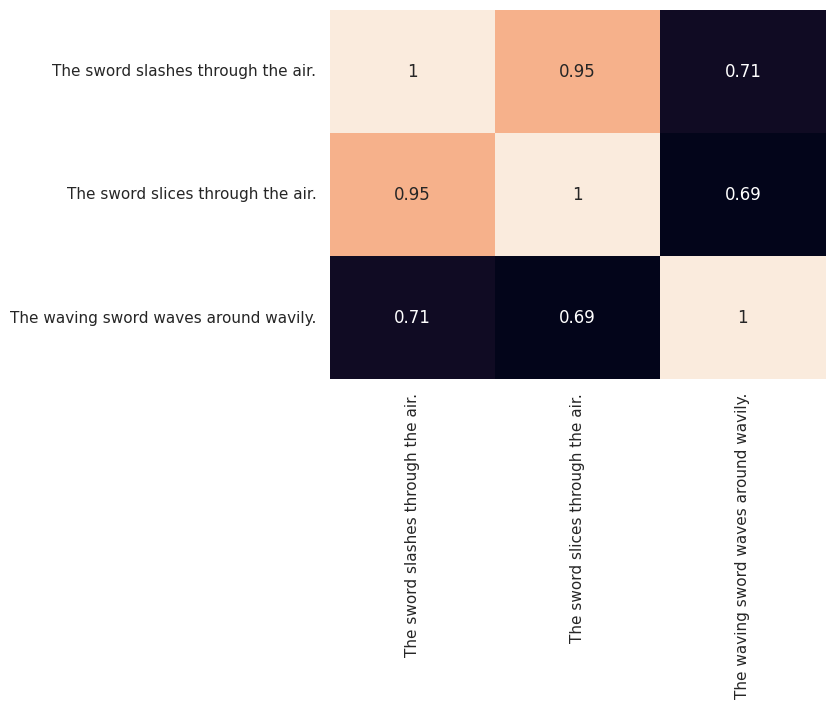

In [30]:
sns.set_theme()
sns.heatmap(c_matrix, xticklabels=captions, yticklabels=captions, annot=True,cbar=False)
plt.savefig('plots/op_cmatrix.png', dpi=600, bbox_inches = "tight")